 # 2DMD at a Glance

The commands below are used to import the libraries used throughout the Jupyter notebook

In [67]:
import io
import re
import ast
import zipfile
import tarfile
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import Parallel, delayed
from collections import Counter, OrderedDict
from itertools import chain
from tqdm.notebook import tqdm
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.periodic_table import Element
from pymatgen.io import cif

## Functions

Functions for data processing and data preparation in the Pandas DataFrame format

In [68]:
BASES_and_CONCENTRATIONS = [['BP_spin', 'high'], ['GaSe_spin', 'high'],
                            ['hBN_spin', 'high'], ['InSe_spin', 'high'],
                            ['MoS2', 'low'], ['MoS2', 'high'],
                            ['WSe2', 'low'], ['WSe2', 'high']
                           ]


def readStructures(base, concentration, structure_ids):

    with zipfile.ZipFile('2d-materials-point-defects-all.zip') as datasets_zip:
        with datasets_zip.open(f'{base}_{concentration}_concentration.zip') as base_zip:
            with zipfile.ZipFile(base_zip) as nested_zip:
                with tarfile.open(fileobj=io.BytesIO(nested_zip.read('initial.tar.gz'))) as tf:
                    cifs = [tf.extractfile(f'{_id}.cif').read().decode("utf-8") 
                            for _id in tqdm(structure_ids)]

    return pd.DataFrame(cifs, index=structure_ids, columns=['cif'])


def parseStructure(cif_string):

    structure = cif.CifParser.from_string(cif_string).get_structures(primitive=False)[0]
    space_group_number = SpacegroupAnalyzer(structure).get_space_group_number()
    lattice = structure.lattice.matrix
    positions = np.array([x.coords for x in structure])
    atomic_symbols = np.array(list(map(lambda x: x.symbol, structure.species)))
    atomic_numbers = np.array(list(map(lambda x: Element(x).number, atomic_symbols)))
    formula = OrderedDict(sorted(Counter(atomic_symbols).items()))
    return [space_group_number, lattice, positions, atomic_symbols, atomic_numbers, formula, 
                         len(atomic_numbers), len(formula)]


def structureFormationEnergy(structure, neat_elements):

    fe = structure['energy']
    formula = structure['formula']
    for element in formula.keys() :
        element_chem_potential = neat_elements.loc[element]['chemical_potential']
        fe -= formula[element] * element_chem_potential
    return fe


def flatList(list_):
    
    return [str(item) for sublist in list_ for item in sublist]


def readDataFromArchive(base, concentration):
    
    with zipfile.ZipFile('2d-materials-point-defects-all.zip') as datasets_zip:
        with datasets_zip.open(f'{base}_{concentration}_concentration.zip') as base_zip:
            with zipfile.ZipFile(base_zip) as nested_zip:
                
                with nested_zip.open('defects.csv.gz') as defects_gz :
                    with gzip.open(defects_gz) as defects_data :
                        defects_df = pd.read_csv(defects_data, sep=',')
                
                with nested_zip.open('descriptors.csv') as descriptors :
                    descriptors_df = pd.read_csv(descriptors, sep=',')
                
                with nested_zip.open('elements.csv') as elements :
                    neat_elements_df = pd.read_csv(elements, sep=',')
                neat_elements_df.set_index('element', inplace=True, drop=True)
                # correction of erroneous chemical potential of nitrogen
                neat_elements_df['chemical_potential'] = -neat_elements_df['chemical_potential'].abs()
                
                with nested_zip.open('initial_structures.csv') as init_structures :
                    init_structures_df = pd.read_csv(init_structures, sep=',')
                    
                with nested_zip.open('targets.csv.gz') as targets_gz :
                    with gzip.open(targets_gz) as targets_data :
                        targets_df = pd.read_csv(targets_data, sep=',')
                        
    return defects_df, descriptors_df, neat_elements_df, init_structures_df, targets_df


def handleTableData(base, concentration) :
    
    defects_df, descriptors_df, neat_elements_df, init_structures_df, targets_df = \
                                                        readDataFromArchive(base, concentration)
    print('\n' + '*'*90 + '\n')
    
    print(f'Information on defects.csv.gz for {base}_{concentration}_concentration')
    for unused_property in ['Unnamed: 0', 'defect_id'] :
        if unused_property in defects_df.columns:
            defects_df.drop(unused_property, axis=1, inplace=True)
    print('\tcolumns:', defects_df.columns)
    print('\tshape:', defects_df.shape)
    number_of_unique = len(defects_df['_id'].unique())
    print(f'\t{number_of_unique} unique defect structures')
    number_of_unique = len(defects_df['descriptor_id'].unique())
    print(f'\t{number_of_unique} unique defect descriptors')

    print(f'Information on descriptors.csv for {base}_{concentration}_concentration')
    for unused_property in ['Unnamed: 0', 'defect_id'] :
        if unused_property in descriptors_df.columns:
            descriptors_df.drop(unused_property, axis=1, inplace=True)
    print('\tcolumns:', descriptors_df.columns)
    print('\tshape:', descriptors_df.shape)
    number_of_unique = len(descriptors_df['_id'].unique())
    print(f'\t{number_of_unique} unique defect descriptors')

    print(f'Information on targets.csv for {base}_{concentration}_concentration')
    for unused_property in ['Unnamed: 0', 'defect_id'] :
        if unused_property in targets_df.columns:
            targets_df.drop(unused_property, axis=1, inplace=True)
    print('\tcolumns:', targets_df.columns)
    print('\tshape:', targets_df.shape)
    number_of_unique = len(targets_df['_id'].unique())
    print(f'\t{number_of_unique} unique defect structures')
    number_of_unique = len(targets_df['descriptor_id'].unique())
    print(f'\t{number_of_unique} unique defect descriptors')

    print('\n' + '*'*90 + '\n')
    print('Data checking...')
    print(f'Is \'descriptor_id\'s (defects.csv) a subset of \'_id\'s (descriptors.csv)?', 
          set(defects_df['descriptor_id']).issubset(set(descriptors_df['_id'])))

    defects_df.set_index('_id', inplace=True, drop=True)
    targets_df.set_index('_id', inplace=True, drop=True)
    descriptors_df.set_index('_id', inplace=True, drop=True)        

    data = pd.DataFrame(descriptors_df.loc[defects_df['descriptor_id']].values, 
                                    columns=descriptors_df.columns, index=defects_df.index)

    for additional_data in [defects_df, targets_df] :
        for piece_of_data in additional_data.columns :
            if (piece_of_data in data.columns) and (additional_data[piece_of_data].dtype != 'O') :
                diff = additional_data[piece_of_data] - data[piece_of_data]
                out_ = np.abs(diff).max()
                print(f'{piece_of_data:>21s} is in the data with the maximum difference of {out_}')
            elif (piece_of_data in data.columns) and (additional_data[piece_of_data].dtype == 'O') :
                out_ = all(data[piece_of_data] == additional_data[piece_of_data])
                print(f'{piece_of_data:>21s} is in the data. Are the column contents the same? {out_}')
            else:
                data[piece_of_data] = additional_data[piece_of_data]

    print('\n' + '*'*90 + '\n')
    cells_available = sorted(data['cell'].unique())
    print('Unique supercells:', cells_available)
    print('\n' + '*'*90 + '\n')
    
    data['defects'] = data['defects'].apply(ast.literal_eval)
    data['defect_nsites'] = data['defects'].apply(len)
                    
    return (data, neat_elements_df, init_structures_df)


def prepareBaseConcentrationDataset(base, concentration, save_to_file=False) :

    data, neat_elements, _ = handleTableData(base, concentration)

    print('Reading structures...')
    structures = readStructures(base, concentration, data.index)
    data = pd.concat((data, structures), axis=1)

    # parse structural info
    print('Parsing structural information...')
    additional_data = Parallel(n_jobs=-1)(delayed(parseStructure)\
                                     (data.loc[_id].cif) 
                                     for _id in tqdm(data.index))
    additional_data = pd.DataFrame(additional_data, index=data.index, 
                        columns=['space_group_no', 'lattice', 'atomic_positions', 'atomic_symbols', 
                                           'atomic_numbers', 'formula', 'nsites', 'nspecies'])

    data = pd.concat((data, additional_data), axis=1)

    # collect additional data
    data['defect_concentration'] = concentration
    data['structure_formation_energy'] = [structureFormationEnergy(data.loc[i], neat_elements) 
                                             for i in data.index]
    data['structure_formation_energy_per_atom'] = data['structure_formation_energy'] / data['nsites']
    data['composition_string'] = data['formula'].apply(lambda x: '_'.join(flatList(list(x.items()))))

    data = data[sorted(data.columns)]
    
    if save_to_file :
        data.to_pickle(f'2d-base_{base}-{concentration}_defect_concentration-table.pkl.gz')
    
    return data


def prepareFullDataset(save_to_file=True, filename='2d-materials-point-defects-all-table.pkl.gz'):
    
    base_datasets = [prepareBaseConcentrationDataset(base, concentration) 
                         for base, concentration in BASES_and_CONCENTRATIONS]
    
    full_dataset = pd.concat(base_datasets, axis=0)

    full_dataset['ordinal_id'] = list(map(float, range(full_dataset.shape[0])))
    full_dataset = full_dataset[sorted(full_dataset.columns)]
    print(f'Full dataset shape is {full_dataset.shape}')
    
    if save_to_file:
        full_dataset.to_pickle(filename)
        return None
    
    else:
        return full_dataset

## Processing Datasets (run one time)

## Handle data

### fast screening routines

In [69]:
full_dataset = pd.read_pickle('2d-materials-point-defects-all-table.pkl.gz')
print(f'Dataset shape (objects, features) is {full_dataset.shape}')
print(f'Number of unique structure ids is {len(full_dataset.index.unique())}')

Dataset shape (objects, features) is (14866, 45)
Number of unique structure ids is 14866


In [70]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14866 entries, P_P141N1_dd6a5668-efc9-4f4c-aee8-ac3472eaf09f to WSe2_Mo4W56Se112S8_e7031dcd-1621-4756-bd39-273b0b78aea9
Data columns (total 45 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   E_1                                  1000 non-null   float64
 1   E_1_majority                         2000 non-null   float64
 2   E_1_minority                         2000 non-null   float64
 3   atomic_numbers                       14866 non-null  object 
 4   atomic_positions                     14866 non-null  object 
 5   atomic_symbols                       14866 non-null  object 
 6   band_gap                             12866 non-null  float64
 7   band_gap_majority                    14866 non-null  float64
 8   band_gap_minority                    14866 non-null  float64
 9   base                                 14866 non-null  object 
 10  cell 

In [71]:
full_dataset.groupby(['base', 'cell', 'defect_concentration', 'defect_nsites',]).size()

base  cell       defect_concentration  defect_nsites
BN    [8, 8, 1]  high                  3                 100
                                       6                 100
                                       9                 100
                                       12                100
                                       16                100
GaSe  [6, 6, 1]  high                  3                 100
                                       7                 100
                                       10                100
                                       14                100
                                       18                100
InSe  [6, 6, 1]  high                  3                 100
                                       7                 100
                                       10                100
                                       14                100
                                       18                100
MoS2  [8, 8, 1]  high           

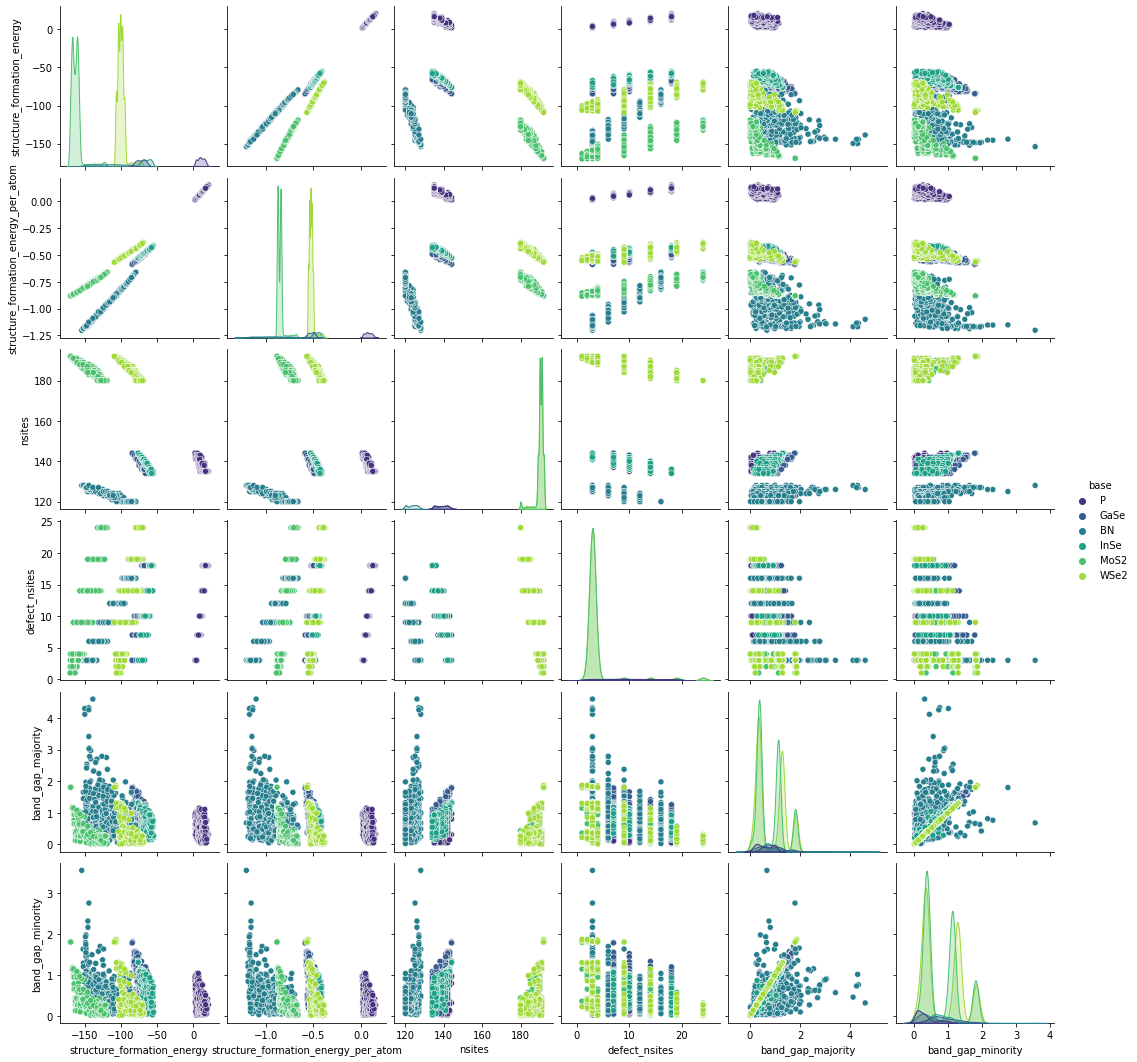

In [72]:
sns.pairplot(full_dataset[['structure_formation_energy',
                           'structure_formation_energy_per_atom',
                           'nsites', 'defect_nsites',
                           'band_gap_majority', 
                           'band_gap_minority',
                           'base']], 
                         hue='base', palette='viridis')

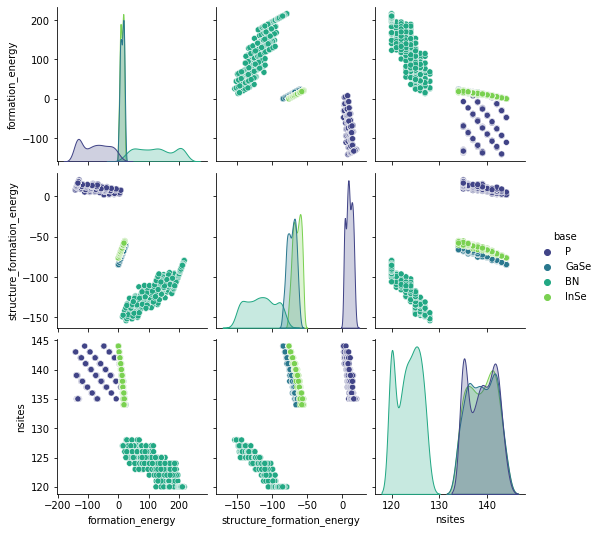

In [73]:
sub_data = full_dataset[(full_dataset['base'] != 'WSe2') & (full_dataset['base'] != 'MoS2')]
sns.pairplot(sub_data[['formation_energy',
                           'structure_formation_energy',
                           'nsites',
                           'base']], 
                         hue='base', palette='viridis')

### data issues

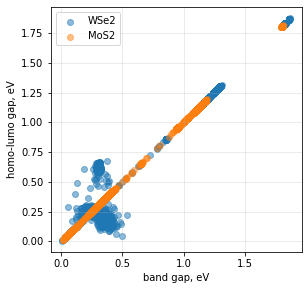

In [64]:
plt.figure(figsize=(4.5, 4.5))
for base in ['WSe2', 'MoS2'] :
    plt.scatter(full_dataset[full_dataset['base'] == base]['band_gap'],
                   full_dataset[full_dataset['base'] == base]['lumo'] - \
                   full_dataset[full_dataset['base'] == base]['homo'], label=base, alpha=0.5)
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('band gap, eV')
plt.ylabel('homo-lumo gap, eV')
plt.show()

In [65]:
for base in ['WSe2', 'MoS2'] :
    print(base)
    print(all(np.isclose(full_dataset[full_dataset['base'] == base]['lumo'],
                    full_dataset[full_dataset['base'] == base]['lumo_minority'])))
    print(all(np.isclose(full_dataset[full_dataset['base'] == base]['lumo'],
                    full_dataset[full_dataset['base'] == base]['lumo_majority'])))
    print(all(np.isclose(full_dataset[full_dataset['base'] == base]['homo'],
                    full_dataset[full_dataset['base'] == base]['homo_majority'])))
    print(all(np.isclose(full_dataset[full_dataset['base'] == base]['homo'],
                    full_dataset[full_dataset['base'] == base]['homo_majority'])))
    print()

WSe2
True
True
True
True

MoS2
True
True
True
True



### visual for the site

In [66]:
vis_subset = full_dataset.loc[['P_P126N9_314e6036-22ea-459f-baa1-603a415ca576',
                               'BN_B58C4N64_8eaeaa60-6bdb-40d8-ab1c-b6734d8e0111',
                               '6141f8669cbada84a8676bab',
                               'GaSe_In1Ga70Se71S1_767bc621-755c-4eef-ac72-187559b2a24f',
                               'InSe_In66Ga5Se71S1_0094c69b-73b6-4191-adba-c4f7bc4491f5',
                 
                 ]][['defects', 'defect_nsites', 'cell',
                     'structure_formation_energy_per_atom', 'composition_string']]

for vis_id in vis_subset.index :
    print(vis_subset.loc[vis_id]['cell'])
    print(vis_subset.loc[vis_id]['defects'])
    print(vis_subset.loc[vis_id]['composition_string'])
    
    print(min(full_dataset[full_dataset['composition_string'] == vis_subset.loc[vis_id]['composition_string']]\
    ['structure_formation_energy_per_atom']))
    print()

[6, 6, 1]
[{'type': 'substitution', 'from': 'P', 'to': 'N'}, {'type': 'substitution', 'from': 'P', 'to': 'N'}, {'type': 'vacancy', 'element': 'P'}, {'type': 'substitution', 'from': 'P', 'to': 'N'}, {'type': 'substitution', 'from': 'P', 'to': 'N'}, {'type': 'vacancy', 'element': 'P'}, {'type': 'vacancy', 'element': 'P'}, {'type': 'substitution', 'from': 'P', 'to': 'N'}, {'type': 'substitution', 'from': 'P', 'to': 'N'}, {'type': 'vacancy', 'element': 'P'}, {'type': 'vacancy', 'element': 'P'}, {'type': 'substitution', 'from': 'P', 'to': 'N'}, {'type': 'substitution', 'from': 'P', 'to': 'N'}, {'type': 'substitution', 'from': 'P', 'to': 'N'}, {'type': 'vacancy', 'element': 'P'}, {'type': 'vacancy', 'element': 'P'}, {'type': 'vacancy', 'element': 'P'}, {'type': 'vacancy', 'element': 'P'}]
N_9_P_126
0.09077161096296196

[8, 8, 1]
[{'type': 'substitution', 'from': 'B', 'to': 'C'}, {'type': 'substitution', 'from': 'B', 'to': 'C'}, {'type': 'substitution', 'from': 'B', 'to': 'C'}, {'type': 'subs

### Sample Machine Learning Routines

In [51]:
print('full dataset shape is', full_dataset.shape)
MoS2_dataset = full_dataset[full_dataset['base'] == 'MoS2'].copy()
print('MoS2 dataset shape is', MoS2_dataset.shape)

full dataset shape is (14866, 45)
MoS2 dataset shape is (6433, 45)


In [52]:
MoS2_dataset[['defects', 'description']]

,defects,description
_id,,
6141cf0efbfd4bd9ab2c2f7e,"[{'type': 'vacancy', 'element': 'S'}]",X1
6141cf0f51c1cbd9654b8870,"[{'type': 'vacancy', 'element': 'S'}, {'type':...",X2
6141cf0fe689ecc4c43cdd4b,"[{'type': 'substitution', 'from': 'S', 'to': '...",X3
6141cf10b842c2e72e2f2d44,"[{'type': 'substitution', 'from': 'S', 'to': '...",X4
6141cf1051c1cbd9654b8872,"[{'type': 'vacancy', 'element': 'S'}, {'type':...",X2
...,...,...
MoS2_Mo56W4Se8S112_347fa841-1f27-46b8-857a-8968015fb7b2,"[{'type': 'substitution', 'from': 'S', 'to': '...",Mo56W4Se8S112
MoS2_Mo56W4Se8S112_46fc57c3-dc25-4119-973c-ba464abbdfab,"[{'type': 'substitution', 'from': 'S', 'to': '...",Mo56W4Se8S112
MoS2_Mo56W4Se8S112_b9ac74d9-367f-400b-b141-71b10700174c,"[{'type': 'substitution', 'from': 'S', 'to': '...",Mo56W4Se8S112


In [53]:
def getDefectDescription(defects):
    
    decoded = [defect['element']+'_vac' if 'element' in defect.keys()
                else defect['from']+'_subst_by_'+defect['to'] 
                for defect in defects]
    return Counter(decoded)


def addUniqueDefectTable(data):
    
    defect_counters = data['defects'].apply(getDefectDescription)
    all_defects = map(lambda x: list(x.keys()), defect_counters)
    unique_defects = sorted(list(set(chain.from_iterable(all_defects))))
    defect_table = [[defect_counter[unique_defect] if unique_defect in defect_counter.keys() else 0
                     for unique_defect in unique_defects]
                    for defect_counter in defect_counters ]
    defect_table = pd.DataFrame(defect_table, index=data.index, columns=unique_defects)
    descriptive_power = defect_table.drop_duplicates().shape[0] / defect_table.shape[0]
    print(f'defect table distingishes {100*descriptive_power:.3f}% of the structures provided')
    return pd.concat((data, defect_table), axis=1), unique_defects

In [54]:
MoS2_dataset, unique_defects = addUniqueDefectTable(MoS2_dataset)
features = unique_defects + ['nspecies', 'nsites', 'defect_nsites', 'space_group_no']

defect table distingishes 3.233% of the structures provided


In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

model = GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, ), 
                     param_grid={'n_estimators':range(100, 400, 50)}, )

train size 96 test size 1287
rmse =  0.022996416106572413
train size 4745 test size 1287
rmse =  0.022048138173288663
train size 4825 test size 1287
rmse =  0.015001902273387411


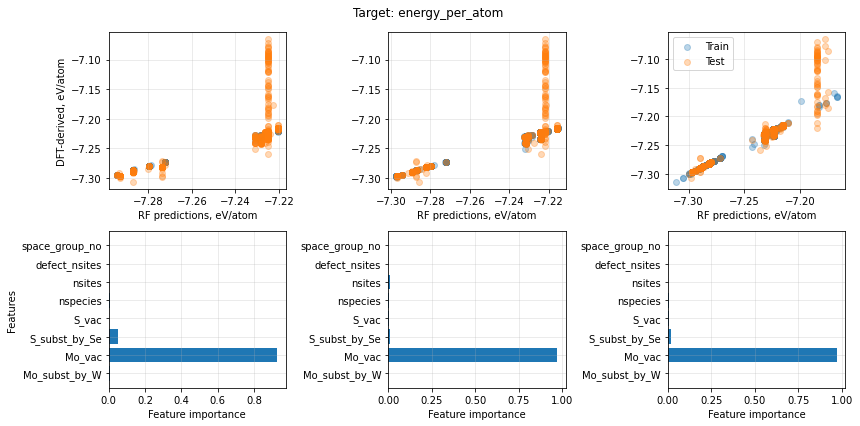

train size 96 test size 1287
rmse =  0.027513801394472365
train size 4745 test size 1287
rmse =  0.024656143910019204
train size 4825 test size 1287
rmse =  0.01943411987181513


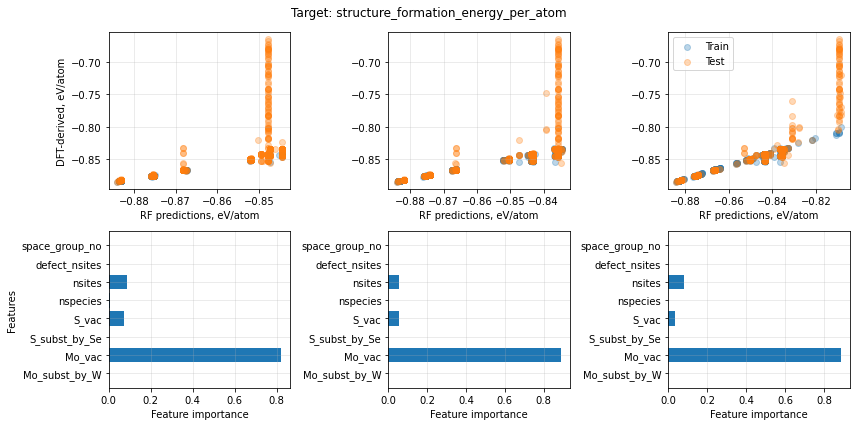

train size 96 test size 1287
rmse =  16.665250924640716
train size 4745 test size 1287
rmse =  14.490925985521551
train size 4825 test size 1287
rmse =  11.889103288735678


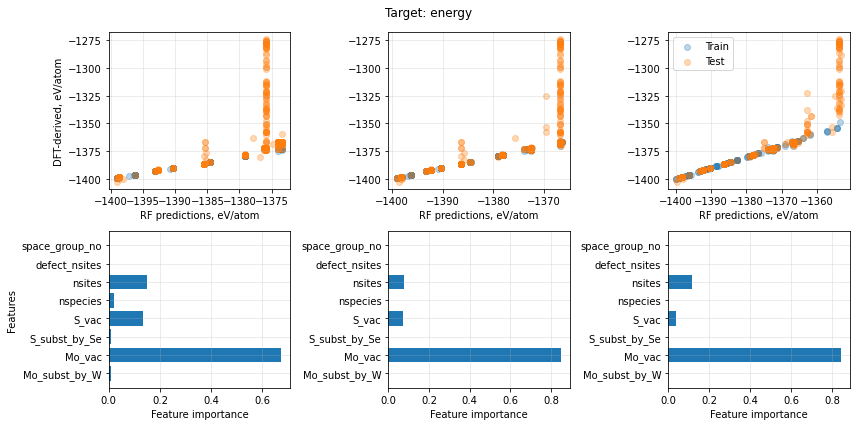

train size 96 test size 1287
rmse =  6.505761415677518
train size 4745 test size 1287
rmse =  5.667142502358978
train size 4825 test size 1287
rmse =  4.574257458770255


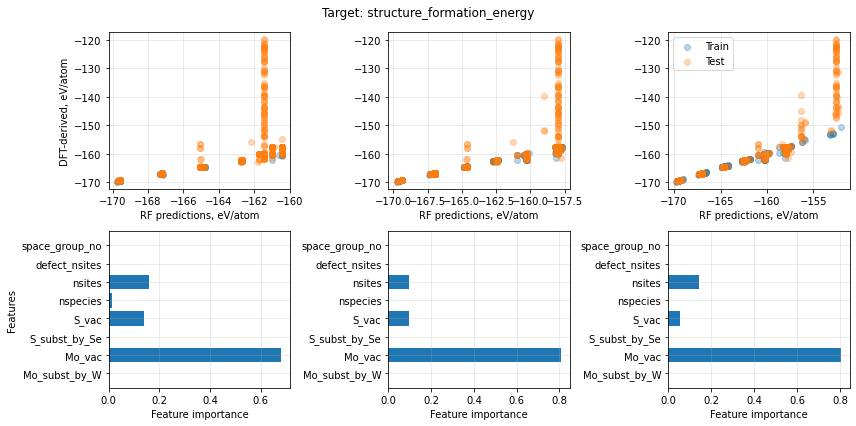

In [56]:
MoS2_train, MoS2_test = train_test_split(MoS2_dataset, test_size=0.2, shuffle=True, random_state=0)

for target in ['energy_per_atom', 'structure_formation_energy_per_atom', 
               'energy', 'structure_formation_energy',]:

    fig, axs = plt.subplots(2, 3, figsize=(12,6))
    plt.suptitle(f'Target: {target}')
    axs[0,0].set_ylabel(f'DFT-derived, eV/atom')
    axs[1,0].set_ylabel(f'Features')
    for kk in range(3) :
        plt.sca(axs[1,kk])
        if kk == 0 : 
            plt.yticks(range(len(features)), features)
        else :
            plt.yticks(range(len(features)), features)

    for ind, i in enumerate(range(2,5)) :
        MoS2_train_reduced = MoS2_train[MoS2_train['defect_nsites'] <= i]
        print('train size', MoS2_train_reduced.shape[0], 'test size', MoS2_test.shape[0])

        model.fit(MoS2_train_reduced[features], MoS2_train_reduced[target])
        dft_values = MoS2_test[target]
        predictions = model.predict(MoS2_test[features])
        print('rmse = ', mse(dft_values, predictions, squared=False))

        axs[0,ind].scatter(model.predict(MoS2_train_reduced[features]),
                    MoS2_train_reduced[target], label='Train', alpha=0.3)
        axs[0,ind].scatter(predictions, dft_values, label='Test', alpha=0.3)

        axs[0,ind].set_xlabel('RF predictions, eV/atom')
        axs[0,ind].grid(alpha=0.3)
        
        feat_imp = model.best_estimator_.feature_importances_
        axs[1,ind].barh(range(len(features)), width=feat_imp)
        axs[1,ind].set_xlabel('Feature importance')
        
        axs[1,ind].grid(alpha=0.3)
        
    axs[0,ind].legend()
    
    plt.tight_layout()
    plt.show()

### Sample input for Graph Neural Networks (Allegro)

In [39]:
def allegroInput(dataset_file) :
    
    print(f'Allegro input generation for {dataset_file}')
    data = pd.read_pickle(dataset_file)
    dataset_xyz = re.sub('pkl.gz', 'xyz', dataset_file)
    with open(dataset_xyz, 'w') as out :
        for index in tqdm(data.index) :
            item = data.loc[index]
            lattice = item['lattice']
            atomic_symbols = item['atomic_symbols']
            positions = item['atomic_positions']
            fe = item['structure_formation_energy']
            fe_pa = item['structure_formation_energy_per_atom']
            ordinal_id = item['ordinal_id']

            out.write(f'{item.nsites}\n')
            out.write('Lattice=\"'+' '.join(list(map(str, list((lattice).reshape(-1,)))))+'\" ')
            out.write('Properties=species:S:1:pos:R:3 pbc=\"T T F\"  ') 
            out.write(f'ordinal_id={ordinal_id} \
                        structure_formation_energy={fe} \
                        structure_formation_energy_per_atom={fe_pa} ')        
            out.write('\n')
            for symbol, pos in zip(atomic_symbols, positions) :
                out.write(symbol + '   ' + ' '.join(list(map(str, pos)))+'\n')

In [29]:
allegroInput(dataset_file='2d-materials-point-defects-all-table.pkl.gz')

Allegro input generation for 2d-materials-point-defects-all-table.pkl.gz


  0%|          | 0/14866 [00:00<?, ?it/s]